# Práctica 2. Fundamentos Análisis

### Daniel Pérez Efremova 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from scipy import stats
import numpy.linalg as alg
import seaborn as sns

In [2]:
data = pd.read_csv('bank-additional-filtered.csv').iloc[:, 1:] # lectura de datos
data.drop('pdays', axis=1, inplace=True)
data.dropna(axis=0, inplace=True)

Se separan las columnas numericas y categoricas para usar los distintos métodos.

In [3]:
numeric_cols = ['age',	'duration',	'campaign',	'previous', 'nr.employed']
object_cols = set(data.columns) - set(numeric_cols) 
object_cols = set(data.columns) - set(data.select_dtypes(include=np.number).columns) 

In [4]:
data_numeric = data[numeric_cols]
data_object = data[object_cols]
y = data['y']

In [5]:
data_object

,basic_education,month,housing,y,job,loan,active,day_of_week,age_binned,education,marital,contact,poutcome
0,True,may,no,no,housemaid,no,False,mon,"(25, 65]",basic_4y,married,False,nonexistent
1,False,may,no,no,services,no,True,mon,"(25, 65]",high_school,married,False,nonexistent
2,False,may,yes,no,services,no,True,mon,"(25, 65]",high_school,married,False,nonexistent
3,True,may,no,no,admin.,no,True,mon,"(25, 65]",basic_6y,married,False,nonexistent
4,False,may,no,no,services,yes,True,mon,"(25, 65]",high_school,married,False,nonexistent
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,False,nov,yes,yes,retired,no,False,fri,"(65, 98]",professional_course,married,False,nonexistent
41184,False,nov,no,no,blue-collar,no,True,fri,"(25, 65]",professional_course,married,False,nonexistent
41185,False,nov,yes,no,retired,no,False,fri,"(25, 65]",university_degree,married,False,nonexistent
41186,False,nov,no,yes,technician,no,True,fri,"(25, 65]",professional_course,married,False,nonexistent


# 1. U-Mann-Whitney y Chi-Square

In [6]:
def wilcoxon_test(df1, df2):
  
    list_col_1 = df1.columns
    list_col_2 = df2.columns
    dict_column = {}

    for i in range(0, len(list_col_1)):
        pvalue_list = []
        name_row = []
        name = list_col_1[i]
        for j in range(0, len(list_col_2)):
            name_check = list_col_2[j]
            name_row.append(name_check)
            stat, pvalue = stats.mannwhitneyu(df1[name], df2[name_check])
            pvalue_list.append(round(pvalue, 2))

        dict_column.update({str(name): pvalue_list})

    df = pd.DataFrame(dict_column)
    df.reset_index(inplace = True)
    df.loc[:, ['Name']] = name_row
    df = df.set_index(['Name'])
    df = df.drop('index', axis = 1)

    return df

In [7]:
wilcoxon_test(data_numeric, data_numeric)

,age,duration,campaign,previous,nr.employed
Name,,,,,
age,1.00,0.81,0.0,0.0,0.0
duration,0.81,1.00,0.0,0.0,0.0
campaign,0.00,0.00,1.0,0.5,0.0
previous,0.00,0.00,0.5,1.0,0.0
nr.employed,0.00,0.00,0.0,0.0,1.0


Se deben eliminar una de cada par de variables (age, duration) y (previous, campaign)

In [8]:
def chisquare_test(df1, df2):
  
    list_col_1 = df1.columns
    list_col_2 = df2.columns
    dict_column = {}

    for i in range(0, len(list_col_1)):
        pvalue_list = []
        name_row = []
        name = list_col_1[i]
        for j in range(0, len(list_col_2)):
            name_check = list_col_2[j]
            name_row.append(name_check)
            pvalue = stats.chisquare(pd.crosstab(df1[name], df2[name_check]))[1][0]
            pvalue_list.append(round(pvalue, 2))

        dict_column.update({str(name): pvalue_list})

    df = pd.DataFrame(dict_column)
    df.reset_index(inplace = True)
    df.loc[:, ['Name']] = name_row
    df = df.set_index(['Name'])
    df = df.drop('index', axis = 1)

    return df

In [9]:
result = chisquare_test(data_object, data_object)

<AxesSubplot:ylabel='Name'>

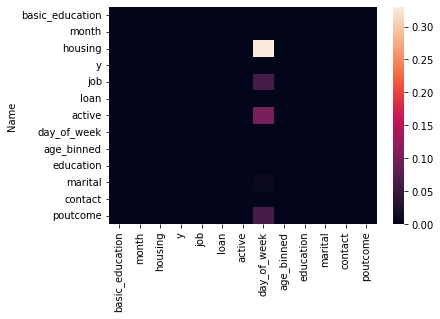

In [10]:
sns.heatmap(result)

Se observa cierta correlación con distintas variables: housing, job, active y poutcome. Puede tener que ver con los planes u horarios de trabajo de los empleados y clientes. Es una relación que debe ignorarse por tener un caractrer espúreo o bien eliminarse day_of_week para evitar problemas de colinealidad en un posible modelo de clasificación.

# Ejercicio 2

In [11]:
x_ob, y = data_object.drop('y', axis=1), data['y']

In [13]:
mi_objects = mutual_info_classif(x_ob.apply(LabelEncoder().fit_transform), y, discrete_features=True)
mutual_info_objects = pd.Series(mi_objects)
mutual_info_objects.index = x_ob.columns
mutual_info_objects.index = x_ob.columns
mutual_info_objects.sort_values(ascending=False)

contact            0.030843
poutcome           0.030385
month              0.026378
job                0.009818
age_binned         0.007948
active             0.004664
education          0.002384
basic_education    0.001479
marital            0.001404
day_of_week        0.000322
housing            0.000062
loan               0.000011
dtype: float64

Se concluye que las variables categóricas no contienen demasiada información común ya que MI $\approx$ 0.

In [14]:
x_num = data_numeric
mutual_info = mutual_info_classif(x_num, y)
mutual_info = pd.Series(mutual_info)
mutual_info.index = data_numeric.columns
mutual_info.sort_values(ascending=False)

duration       0.075152
nr.employed    0.063909
previous       0.022700
age            0.014190
campaign       0.001252
dtype: float64


Se concluye que las variables continuas no contienen demasiada información común ya que MI  ≈  0.

# Ejercicio 3. LDA

In [15]:
lda = LinearDiscriminantAnalysis(n_components=1, store_covariance=True).fit(data_numeric, data['y'])

Los autovalores de la matriz de covarianzas son:

In [16]:
alg.eig(lda.covariance_)[1][0]

array([ 0.04473098, -0.01305987,  0.78293967,  0.62012027, -0.0168788 ])

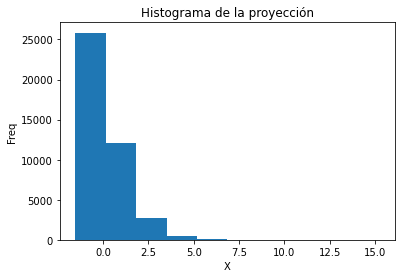

In [17]:
plt.hist(lda.transform(data_numeric)) # histograma de la proyeccion
plt.xlabel('X')
plt.ylabel('Freq')
plt.title('Histograma de la proyección')
plt.show()

In [18]:
lda.covariance_ @ (lda.means_[0]-lda.means_[1]) # vector de proyecccion

array([-0.1002521 , -0.91495526,  0.44765799, -1.08112836,  1.18532741])

# Ejercicio 4. PCA

In [19]:
pca = PCA().fit(data_numeric, y)

La varianza explicada por cada una de las componentes principales es:

In [20]:
pca.explained_variance_ratio_

array([0.31119184, 0.2077373 , 0.1992294 , 0.18313077, 0.09871069])

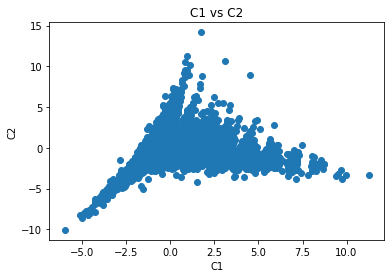

In [21]:
transformed = pca.transform(data_numeric)[:, :2]
plt.scatter(transformed[:, 0], transformed[:, 1]) # gráfico 2d de las dos primeras componentes
plt.xlabel('C1')
plt.ylabel('C2')
plt.title('C1 vs C2')
plt.show()

La matriz de proyección del PCA consiste en autovectores de la matriz de covarianza. 

In [22]:
P = alg.eig(pca.get_covariance())[1]
pd.DataFrame(P)

,0,1,2,3,4
0,0.050005,-0.007918,0.104133,0.276966,-0.953878
1,0.115985,0.021895,-0.583328,-0.754426,-0.276836
2,-0.285961,-0.091924,-0.784685,0.539288,0.056696
3,0.661252,0.693511,-0.164593,0.221444,0.075238
4,-0.681924,0.714178,0.077870,-0.119423,-0.067851
